# Study model selection procedure for the "classic" gradient boosting algorithm

## Imports

In [2]:
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from optuna.study import MaxTrialsCallback
import timeout_decorator
from joblib import Parallel, delayed
import multiprocessing
from sklearn.metrics import log_loss
from sklearn.utils.class_weight import compute_class_weight
# add to path
import sys
sys.path.append("../")
from utils import load_lhco_rd, multi_roc_sigeffs, HGBPipeline
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

## Load data and define necessary functions

In [4]:
datadict = load_lhco_rd("../treebased_ad_files/", shuffle=True)

x_full = np.concatenate((datadict["x_train"], datadict["x_val"]))
y_full = np.concatenate((datadict["y_train_databg"], datadict["y_val_databg"]))

In [5]:
def get_sample_weights(y):
    class_weights = compute_class_weight(
        class_weight='balanced', classes=np.unique(y), y=y,
        )

    sample_weights = ((np.ones(y.shape) - y)*class_weights[0]
                      + y*class_weights[1])
    
    return sample_weights

## Define the classifier: First standardize data, then use gradient boosting classifier with 200 estimators and default values for all other parameters

In [6]:
clsf_hist_model = GradientBoostingClassifier(
    n_estimators=200,
)

steps = [("scaler", StandardScaler()),
         ("classifier", clsf_hist_model)]

model = HGBPipeline(steps=steps)

Compute weights and fit

In [7]:
train_weights = get_sample_weights(datadict["y_train_databg"])
model.fit(datadict["x_train"], datadict["y_train_databg"], classifier__sample_weight=train_weights)

HGBPipeline(steps=[('scaler', StandardScaler()),
                   ('classifier',
                    GradientBoostingClassifier(n_estimators=200))])

Get train and val losses

In [8]:
# get train losses
train_losses = []
train_weights = get_sample_weights(datadict["y_train_databg"])

for preds in model.staged_predict_proba(datadict["x_train"]):

    train_losses.append(log_loss(datadict["y_train_databg"], preds[:, 1],
                                 sample_weight=train_weights))

min_train_loss = np.min(train_losses)

In [9]:
# get val losses
val_losses = []
val_weights = get_sample_weights(datadict["y_val_databg"])

for preds in model.staged_predict_proba(datadict["x_val"]):

    val_losses.append(log_loss(datadict["y_val_databg"], preds[:, 1],
                                 sample_weight=val_weights))

min_val_loss = np.min(val_losses)

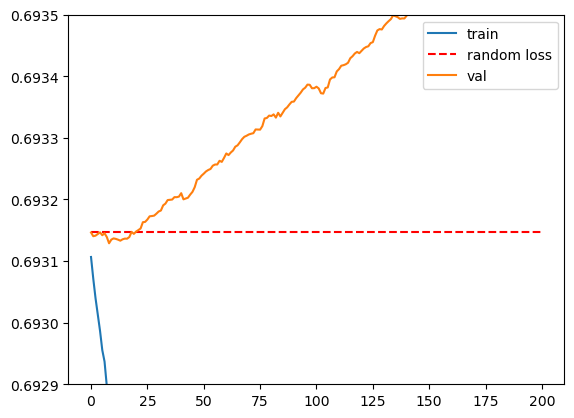

In [11]:
plt.plot(train_losses, label="train")
plt.hlines(-np.log(0.5), 0, 200, color="red", ls="dashed", label="random loss")
plt.plot(val_losses, label="val")
# zoom in a bit to see the minimum of the validation loss better
plt.ylim(0.6929, 0.6935)
plt.legend()
plt.show()

We see that the training loss goes down sharply, while the validation loss goes down initially, but then starts to increase again. While this is a clear sign of overfitting, we do get a valid minimum that can be used for model selection.

### Look at loss curves for signal and background events separately

In [12]:
# get separate signal and background losses for training set

train_losses_sig = []
train_losses_bg = []

x_train_sig = datadict["x_train"][datadict["y_train_sigbg"] == 1]
x_train_bg = datadict["x_train"][datadict["y_train_sigbg"] == 0]
train_weights_sig = train_weights[datadict["y_train_sigbg"] == 1]
train_weights_bg = train_weights[datadict["y_train_sigbg"] == 0]

for preds in model.staged_predict_proba(x_train_sig):
    

    train_losses_sig.append(
        log_loss(datadict["y_train_databg"][datadict["y_train_sigbg"] == 1],
                 preds[:, 1], labels=[0, 1],
                 sample_weight=train_weights_sig))


for preds in model.staged_predict_proba(x_train_bg):

    train_losses_bg.append(
        log_loss(datadict["y_train_databg"][datadict["y_train_sigbg"] == 0],
                 preds[:, 1], labels=[0, 1],
                 sample_weight=train_weights_bg))

In [13]:
# get separate signal and background losses for validation set

val_losses_sig = []
val_losses_bg = []

x_val_sig = datadict["x_val"][datadict["y_val_sigbg"] == 1]
x_val_bg = datadict["x_val"][datadict["y_val_sigbg"] == 0]
val_weights_sig = val_weights[datadict["y_val_sigbg"] == 1]
val_weights_bg = val_weights[datadict["y_val_sigbg"] == 0]

for preds in model.staged_predict_proba(x_val_sig):
    

    val_losses_sig.append(
        log_loss(datadict["y_val_databg"][datadict["y_val_sigbg"] == 1],
                 preds[:, 1], labels=[0, 1],
                 sample_weight=val_weights_sig))


for preds in model.staged_predict_proba(x_val_bg):

    val_losses_bg.append(
        log_loss(datadict["y_val_databg"][datadict["y_val_sigbg"] == 0],
                 preds[:, 1], labels=[0, 1],
                 sample_weight=val_weights_bg))

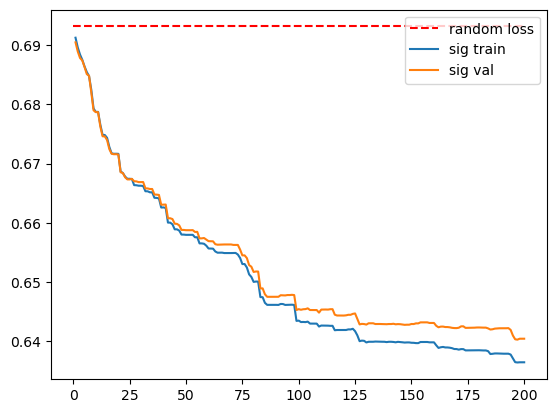

In [14]:
# signal losses
x_axis = np.arange(1, 201)
plt.hlines(-np.log(0.5), 0, 200, color="red", ls="dashed", label="random loss")
plt.plot(x_axis, train_losses_sig, label="sig train")
plt.plot(x_axis, val_losses_sig, label="sig val")
plt.legend()
plt.savefig("sig_losses_xgboost.pdf", bbox_inches="tight")
plt.show()

We can clearly see that the loss of the signal events decreases continuously both for training and validation set events. However, at around 125 iterations, the decrease of the loss stalls out and barely decreases any further.

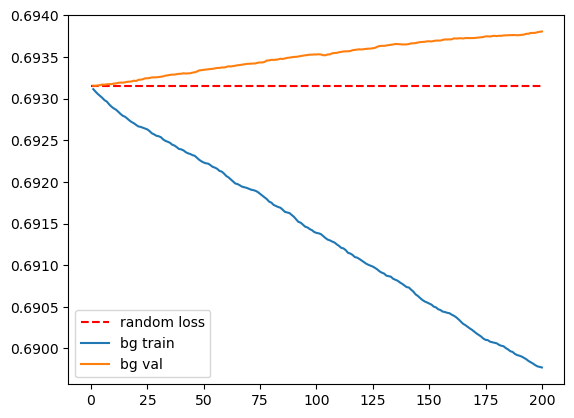

In [15]:
# background losses
x_axis = np.arange(1, 201)
plt.hlines(-np.log(0.5), 0, 200, color="red", ls="dashed", label="random loss")
plt.plot(x_axis, train_losses_bg, label="bg train")
plt.plot(x_axis, val_losses_bg, label="bg val")
#plt.ylim(0.68, 0.71)
plt.savefig("bg_losses_xgboost.pdf", bbox_inches="tight")
plt.legend()
plt.show()

For background events, we basically overfit from the beginning: the training loss decreases continuously, while the validation loss increases from the get-go.

Summing up, we can say that the signal is learned best at very high iterations, while the background performance is best at low iterations, where the overfitting is still small.

Next, lets repeat the full loss plot from before, not adjusting the y axis range to see the entire plot.

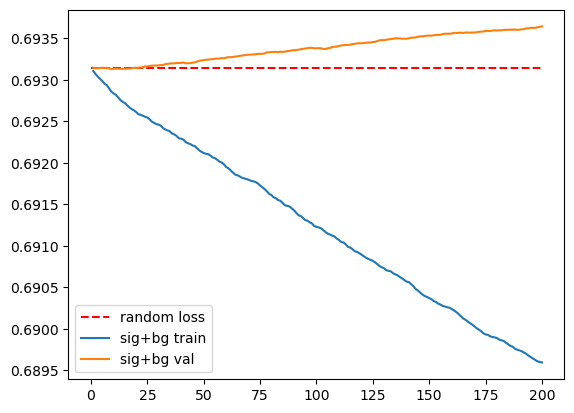

In [16]:
# full losses
x_axis = np.arange(1, 201)
plt.hlines(-np.log(0.5), 0, 200, color="red", ls="dashed", label="random loss")
plt.plot(x_axis, train_losses, label="sig+bg train")
plt.plot(x_axis, val_losses, label="sig+bg val")
#plt.ylim(0.68, 0.71)
plt.legend()
plt.show()

The plot is clearly dominated by the quickly decreasing losses of both signal and background events for the training set, while the validation loss first decreases due to the fast reduction in signal loss, but then increases again due to the overfitting of the background events. Therefore, a valid minimum iteration can be selected.

One interesting study is to look at the prediction distributions at different iterations:
- At the first iteration, the background overfitting is minimal, so it is the best iteration for background rejection w.r.t. validation loss
- At the last iteration, the signal is learned best, so it is the best iteration for signal efficiency w.r.t. validation loss
- Finally, we look at the iteration with the overall lowest validation loss, which is somewhere in between the two extremes

In [16]:
for idx, preds in enumerate(model.staged_predict_proba(datadict["x_test"])):
    if idx == 1:
        preds_one = preds[:, 1]
        break

preds_final = model.predict_proba(datadict["x_test"])[:, 1]

In [17]:
best_iter = np.argmin(val_losses)

for idx, preds in enumerate(model.staged_predict_proba(datadict["x_test"])):
    if idx == best_iter:
        preds_best = preds[:, 1]
        break

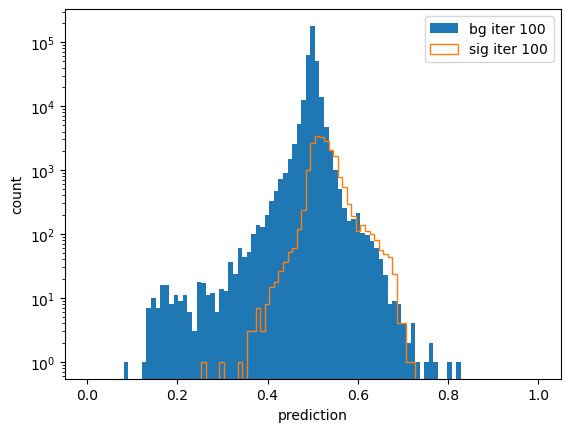

In [18]:
bins = np.linspace(0, 1, 100)
plt.hist(preds_final[datadict["y_test"] == 0], bins=bins, label="bg iter 100")
plt.hist(preds_final[datadict["y_test"] == 1], bins=bins, label="sig iter 100", histtype="step")
plt.legend(loc="upper right")
plt.xlabel("prediction")
plt.ylabel("count")
plt.yscale("log")
plt.show()

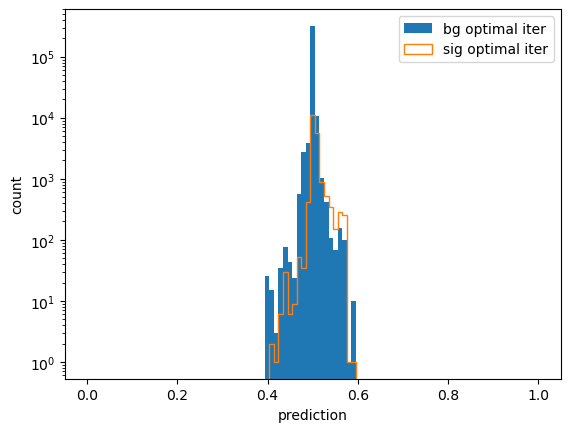

In [19]:
bins = np.linspace(0, 1, 100)
plt.hist(preds_best[datadict["y_test"] == 0], bins=bins, label="bg optimal iter")
plt.hist(preds_best[datadict["y_test"] == 1], bins=bins, label="sig optimal iter", histtype="step")
plt.legend(loc="upper right")
plt.xlabel("prediction")
plt.ylabel("count")
plt.yscale("log")
plt.show()

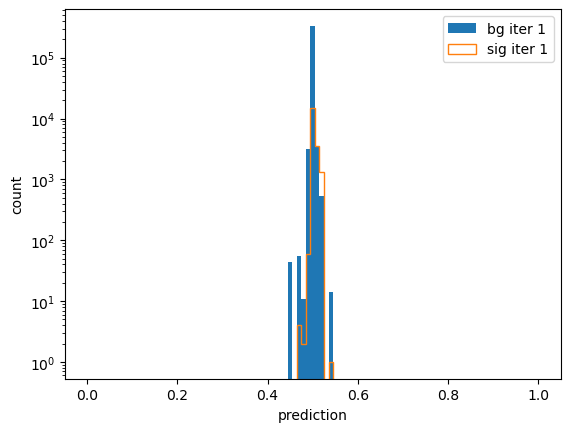

In [20]:
bins = np.linspace(0, 1, 100)
plt.hist(preds_one[datadict["y_test"] == 0], bins=bins, label="bg iter 1")
plt.hist(preds_one[datadict["y_test"] == 1], bins=bins, label="sig iter 1", histtype="step")
plt.legend(loc="upper right")
plt.xlabel("prediction")
plt.ylabel("count")
plt.yscale("log")
plt.show()

The main thing which can be seen is that the variance of the prediciton distributions is way lower for earlier iterations compared to later ones. The separation between signal and background seems similar by eye.

It should be noted that this particular training run has a rather bad performance, with a max SIC of around 3 for the best iteration (and there, it's mainly in a region of high statistical uncertaintiy). So it might be worth to repeat this study with a better performing model. However, it is expected that the overall behaviour of the loss curves stays largely the same.

